<a href="https://colab.research.google.com/github/jess22jess/EDPII/blob/main/Ejercicio_5_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Jessica Beatriz Arcos Gutiérrez**

**EDP II**

---
# Método del Elemento Finito

El método de elementos finitos pertenece a los métodos variacionales, donde la solución se construye combinando funciones simples definidas en pequeñas regiones del dominio llamadas "elementos".

La idea principal es dividir un dominio complejo en muchas partes simples, aproximar la solución dentro de cada elemento con funciones básicas, y ensamblar todas las contribuciones locales en un sistema global de ecuaciones algebraicas.

En esencia, transformamos un problema diferencial continuo y complejo en muchos problemas pequeños y sencillos, cuya solución combinada nos da una buena aproximación a la respuesta buscada.

In [149]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

Buscamos resolver la ecuación
$$-{\frac{d^2 u}{dx^2} = 1-x^2}$$
sujeta a las condiciones
\begin{aligned}
u(0)=u(1)=0
\end{aligned}

Primero buscamos la solución analítica

In [150]:
x = sp.symbols('x') # introducimos una variable
u = sp.Function('u') # esta es una función

In [151]:
ode = -u(x).diff(x, x) - 1 + x**2 # definimos la ecuación
sp.dsolve(ode, u(x))

Eq(u(x), C1 + C2*x + x**4/12 - x**2/2)

In [152]:
sol = sp.dsolve(ode, ics={u(0): 0, u(1): 0})# diccionario
# resolvemos la EDO con condiciones de contorno

In [153]:
sol

Eq(u(x), x**4/12 - x**2/2 + 5*x/12)

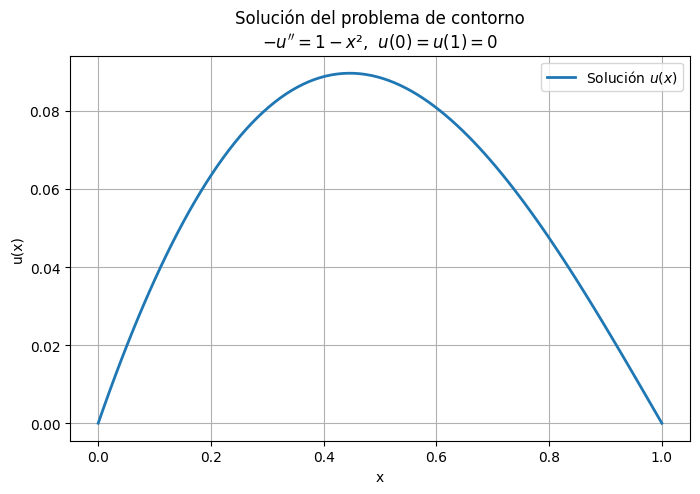

In [154]:
# Convertimos en un arreglo de numpy
u_expr = sol.rhs

u_num = sp.lambdify(x, u_expr, "numpy")

xx = np.linspace(0, 1, 100)
yy = u_num(xx)

plt.figure(figsize=(8,5))
plt.plot(xx, yy, label="Solución $u(x)$", linewidth=2)
plt.title("Solución del problema de contorno\n$-u'' = 1 - x²$,  $u(0)=u(1)=0$")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True)
plt.legend()
plt.show()

In [155]:
# Parámetros
L = 1.0 # dominio
nelem = 4 # número de elementos
nnodos = nelem + 1 # número de nodos
h = L / nelem # longitud del elemento

In [156]:
# Coordenadas de los nodos
cnodos = np.linspace(0, L, nnodos)

In [157]:
cnodos

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [158]:
def f(x):
    return 1 - x**2  # función del lado derecho de -u'' = f(x)

In [159]:
K = np.zeros((nnodos, nnodos))  # matriz de rigidez global
F = np.zeros(nnodos) # vector de carga global

Ambos empiezan en cero porque vamos a sumar contribuciones

In [160]:
k_local = (1/h) * np.array([[1, -1],   # matriz de rigidez local para un elemento
                            [-1, 1]])

# Matriz de rigidez local

Para un elemento lineal de longitud $h$ en el intervalo $x_i, x_{i+1}$, las funciones de forma lineales son:

$\varphi_1(x) = \frac{x_{i+1} - x}{h}, \qquad
\varphi_2(x) = \frac{x - x_i}{h}$

con propiedades:

$\varphi_1(x_i) = 1, \quad \varphi_1(x_{i+1}) = 0, \qquad
\varphi_2(x_i) = 0, \quad \varphi_2(x_{i+1}) = 1.$

Sus derivadas son constantes:

$\varphi_1'(x) = -\frac{1}{h}, \qquad \varphi_2'(x) = \frac{1}{h}.$

La matriz de rigidez elemental se obtiene de:

   $k_{mn} = \int_{x_i}^{x_{i+1}} \varphi_m'(x) \varphi_n'(x) \, dx, \quad m,n = 1,2.$


Calculando cada término:

\begin{aligned}
k_{11} &= \int_{x_i}^{x_{i+1}} \left(-\frac{1}{h}\right)\left(-\frac{1}{h}\right) dx
      = \frac{1}{h^2} \cdot h = \frac{1}{h}, \\[4pt]
k_{22} &= \int_{x_i}^{x_{i+1}} \left(\frac{1}{h}\right)\left(\frac{1}{h}\right) dx
      = \frac{1}{h^2} \cdot h = \frac{1}{h}, \\[4pt]
k_{12} = k_{21} &= \int_{x_i}^{x_{i+1}} \left(-\frac{1}{h}\right)\left(\frac{1}{h}\right) dx
                = -\frac{1}{h^2} \cdot h = -\frac{1}{h}.
\end{aligned}

Por lo tanto, la matriz de rigidez local es:

${k_{\text{local}} = \frac{1}{h}
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}}$

Para nuestro problema con $h = 0.25$:

$k_{\text{local}} = \frac{1}{0.25}
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
= 4
\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
=
\begin{bmatrix}
4 & -4 \\
-4 & 4
\end{bmatrix}.$


In [161]:
k_local

array([[ 4., -4.],
       [-4.,  4.]])

In [162]:
# Ensamblar la matriz K global elemento por elemento
for e in range(nelem):
    nodo_izq = e          # 0, 1, 2, 3
    nodo_der = e + 1      # 1, 2, 3, 4

    # Sumar la contribución de este elemento a K
    K[nodo_izq, nodo_izq] += k_local[0, 0]
    K[nodo_izq, nodo_der] += k_local[0, 1]
    K[nodo_der, nodo_izq] += k_local[1, 0]
    K[nodo_der, nodo_der] += k_local[1, 1]

In [163]:
K

array([[ 4., -4.,  0.,  0.,  0.],
       [-4.,  8., -4.,  0.,  0.],
       [ 0., -4.,  8., -4.,  0.],
       [ 0.,  0., -4.,  8., -4.],
       [ 0.,  0.,  0., -4.,  4.]])

In [164]:
# Para cada elemento en la malla
for e in range(nelem):
    nodo_izq = e  # nodo izquierdo del elemento
    nodo_der = e + 1  # nodo derecho del elemento
    # posición del nodo izq y der.
    x_izq = cnodos[nodo_izq]
    x_der = cnodos[nodo_der]

    x_medio = (x_izq + x_der) / 2 # punto medio del elemento para integración numérica
    f_medio = f(x_medio) # evaluar en el punto medio
    # Calcular contribuciones al vector de carga usando regla del punto medio
    contrib_izq = f_medio * 0.5 * h
    contrib_der = f_medio * 0.5 * h
    # Acumular contribuciones en el vector global F
    F[nodo_izq] += contrib_izq
    F[nodo_der] += contrib_der

#Vector de carga elemental

Para el término fuente $f(x) = 1 - x^2$, el vector de carga se calcula como:

$$
f_m = \int_{x_i}^{x_{i+1}} f(x) \varphi_m(x) \, dx, \quad m=1,2
$$

Usamos integración numérica por la regla del punto medio:

$$
\int_a^b g(x)dx \approx g\left(\frac{a+b}{2}\right) \cdot (b-a)
$$

En el punto medio $x_m = \frac{x_i + x_{i+1}}{2}$, las funciones de forma valen:

$$
\varphi_1(x_m) = \frac{x_{i+1} - x_m}{h} = 0.5, \quad
\varphi_2(x_m) = \frac{x_m - x_i}{h} = 0.5
$$

Entonces:

$$
\begin{aligned}
f_1 &\approx f(x_m) \cdot \varphi_1(x_m) \cdot h = f(x_m) \cdot 0.5 \cdot h \\
f_2 &\approx f(x_m) \cdot \varphi_2(x_m) \cdot h = f(x_m) \cdot 0.5 \cdot h
\end{aligned}
$$

Para $h=0.25$:

$$
f_1 = f_2 = f(x_m) \cdot 0.125
$$

El vector global $F$ se ensambla sumando contribuciones de elementos adyacentes a cada nodo.

In [165]:
F

array([0.12304688, 0.23046875, 0.18359375, 0.10546875, 0.02929688])

Tenemos condiciones Dirichlet homogéneas (nodos fijos):

$$
u(0) = 0, \quad u(1) = 0
$$

Esto corresponde a valores conocidos en los nodos extremos:

$$
u_0 = 0, \quad u_4 = 0
$$

In [166]:
nodos_fijos = [0, 4] # índice 0: x=0, índice 4: x=1

En los nodos libres calcularemos u

In [167]:
nodos_libres = [1, 2, 3] # índices: nodos en x=0.25, 0.5, 0.75

In [168]:
# Reducir el sistema: K_red * u_libres = F_red
K_red = K[np.ix_(nodos_libres, nodos_libres)]  # np.ix_ crea índices para tomar submatriz
F_red = F[nodos_libres]
# Esto es equivalente a K[1:4, 1:4] y F[1:4]

El sistema global $K u = F$ de tamaño $5\times5$ se reduce eliminando las ecuaciones correspondientes a nodos con valores conocidos. Usamos el método de eliminación y así queda el sistema reducido para nodos interiores:

$$
\begin{bmatrix}
8 & -4 & 0 \\
-4 & 8 & -4 \\
0 & -4 & 8
\end{bmatrix}
\begin{bmatrix}
u_1 \\ u_2 \\ u_3
\end{bmatrix}
=
\begin{bmatrix}
0.23046875 \\ 0.18359375 \\ 0.10546875
\end{bmatrix}
$$

Resolviendo este sistema $3\times3$ obtenemos $u_1, u_2, u_3$.

In [169]:
K_red, F_red

(array([[ 8., -4.,  0.],
        [-4.,  8., -4.],
        [ 0., -4.,  8.]]),
 array([0.23046875, 0.18359375, 0.10546875]))

In [179]:
# Resolvemos K_red * u_libres = F_red
u_libres = np.linalg.solve(K_red, F_red)  # np.linalg.solve resuelve Ax=b
u_libres

array([0.07275391, 0.08789062, 0.05712891])

In [180]:
# Crear vector solución completo (todos los nodos)
u_completo = np.zeros(nnodos)  # 5 elementos, todos 0 inicialmente

In [181]:
# Asignar valores conocidos de frontera (condiciones Dirichlet)
u_completo[0] = 0.0    # u(0) = 0
u_completo[4] = 0.0    # u(1) = 0

In [182]:
# Asignar valores calculados para nodos libres
u_completo[1] = u_libres[0]   # u(0.25)
u_completo[2] = u_libres[1]   # u(0.50)
u_completo[3] = u_libres[2]   # u(0.75)

In [183]:
u_completo

array([0.        , 0.07275391, 0.08789062, 0.05712891, 0.        ])

In [189]:
def u_exacta(x):
    return x**4/12 - x**2/2 + 5*x/12  # solución exacta

u_exacta_nodos = u_exacta(cnodos) # evaluamos la solución exacta en los nodos

print("-"*52)
print("Nodo |   x   |    FEM     |   Exacta   |   Error")
print("-"*52)

for i in range(nnodos):
    error = abs(u_completo[i] - u_exacta_nodos[i]) # calcula error absoluto
    print(f"{i:4d} | {cnodos[i]:.3f} | {u_completo[i]:.8f} | {u_exacta_nodos[i]:.8f} | {error:.2e}")

----------------------------------------------------
Nodo |   x   |    FEM     |   Exacta   |   Error
----------------------------------------------------
   0 | 0.000 | 0.00000000 | 0.00000000 | 0.00e+00
   1 | 0.250 | 0.07275391 | 0.07324219 | 4.88e-04
   2 | 0.500 | 0.08789062 | 0.08854167 | 6.51e-04
   3 | 0.750 | 0.05712891 | 0.05761719 | 4.88e-04
   4 | 1.000 | 0.00000000 | 0.00000000 | 0.00e+00


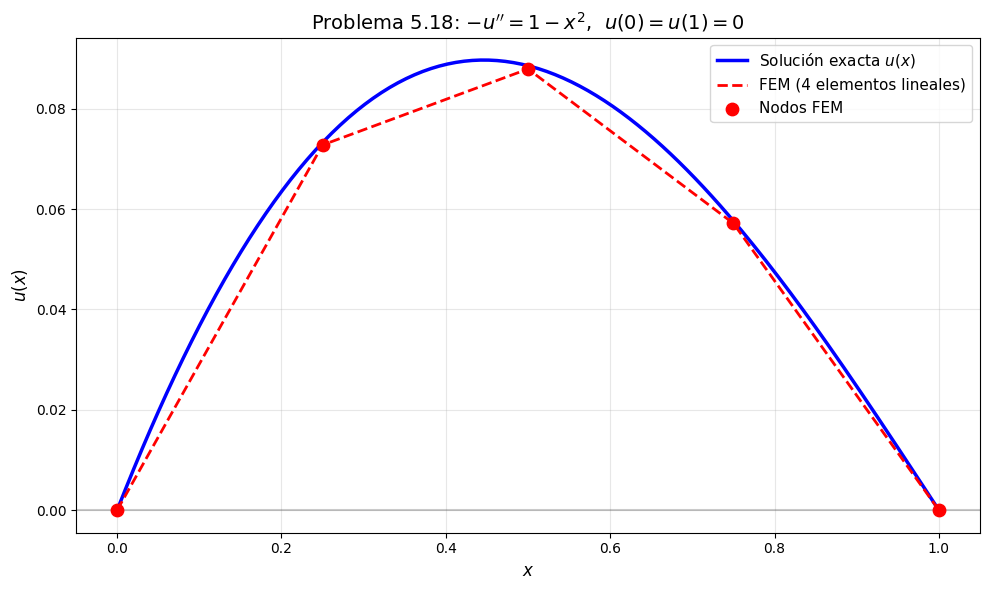

In [190]:
#Solución analítica y numérica
# Puntos para graficar solución exacta (suave)
xx = np.linspace(0, 1, 200)
uu_exacta = u_exacta(xx)

# Para graficar solución FEM (lineal por elementos)
xx_fem = []
uu_fem = []

for e in range(nelem):
    x1 = cnodos[e]
    x2 = cnodos[e+1]
    u1 = u_completo[e]
    u2 = u_completo[e+1]

    # Crear segmento lineal entre (x1,u1) y (x2,u2)
    xx_seg = np.linspace(x1, x2, 20)
    uu_seg = u1 + (xx_seg - x1) * (u2 - u1) / (x2 - x1)

    xx_fem.extend(xx_seg)
    uu_fem.extend(uu_seg)

plt.figure(figsize=(10, 6))

# Graficar soluciones
plt.plot(xx, uu_exacta, 'b-', label='Solución exacta $u(x)$', linewidth=2.5)
plt.plot(xx_fem, uu_fem, 'r--', label='FEM (4 elementos lineales)', linewidth=2)

plt.scatter(cnodos, u_completo, color='red', s=80, zorder=5, label='Nodos FEM') # marcar nodos

plt.title("Problema 5.18: $-u'' = 1 - x^2$,  $u(0)=u(1)=0$", fontsize=14)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$u(x)$", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()

plt.show()

# Conclusión

El método de elementos finitos implementado para el ejercicio 5.18 logra una aproximación numérica satisfactoria. Los errores obtenidos en los nodos interiores son del orden de $10^{-4}$, lo que indica una buena precisión considerando la simplicidad de la malla utilizada. La forma de la solución, con su máximo en la región central, refleja adecuadamente el efecto del término fuente $f(x) = x(1-x)$, y se respetan las condiciones de frontera establecidas.